**Course**: Data Visualization (Prof. Dr. Heike Leitte, Luisa Vollmer, RPTU Kaiserslautern),   **Name**: XXX XXX,   **Date**: DD.MM.YYYY

<div class="alert alert-info">

    
# Assignment 4 - Principal Component Analysis (PCA)
</div>


### Outline and goals

In the fourth assignment, we will explore a cars dataset using principal component analysis. Each car is described by 25 variables. The dataset contains six types of cars and we would like to understand how they are different. The goal of this assignment is that you are able to:
- explore high-dimensional data with many variables
- compute and interpret PCA
- charactize groups in the PCA plot
- find patterns and outliers in data with many variables

<div class="alert alert-danger">

**Important**: While no points will be awarded for typing the correct answers in the notebooks, it is highly advised to solve the tasks thoroughly. They are designed to be encouraging and provide you with valuable learnings for the exam, understanding of the methods and practical coding.
</div>

<div class="alert alert-success">
    
All tasks in this notebook are marked in green.
</div>

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper, CategoricalColorMapper
from bokeh.models import Arrow, NormalHead, LabelSet, Label
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category10, Category20, Viridis
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.io import export_png
from bokeh.layouts import gridplot, row
from bokeh.core.properties import value
from bokeh.models.tickers import FixedTicker

from math import pi

output_notebook()

Loading BokehJS ...

<div class="alert alert-info">
    
## 1. Load the 1993 cars dataset
</div>

First, we load the data and handle missing values. We ignore the variable LUGGAGE CAPACITY which has no information for vans and some missing values. We also drop two cars with missing values.

Description of variables:
- Manufacturer
- Model
- Type: Small, Sporty, Compact, Midsize, Large, Van
- Minimum Price (in \$1,000) - Price for basic version of this model
- Midrange Price (in \$1,000) - Average of Min and Max prices
- Maximum Price (in \$1,000) - Price for a premium version
- City MPG (miles per gallon by EPA rating)
- Highway MPG
- Air Bags standard 0 = none, 1 = driver only, 2 = driver & passenger
- Drive train type 0 = rear wheel drive 1 = front wheel drive 2 = all wheel drive
- Number of cylinders
- Engine size (liters)
- Horsepower (maximum)
- RPM (revs per minute at maximum horsepower)
- Engine revolutions per mile (in highest gear)
- Manual transmission available 0 = No, 1 = Yes
- Fuel tank capacity (gallons)
- Passenger capacity (persons)
- Length (inches)
- Wheelbase (inches)
- Width (inches)
- U-turn space (feet)
- Rear seat room (inches)
- Luggage capacity (cu. ft.)
- Weight (pounds)
- Domestic? 0 = non-U.S. manufacturer 1 = U.S. manufacturer

In [2]:
# load the data
cars = pd.read_csv( '93cars.dat.csv', sep='\s+', na_values='*')
print("size of input dataframe", cars.shape)


# substitute missing values
cars.drop(['LuggageCapacity'], axis=1, inplace=True)
cars.dropna(inplace=True)
cars.reset_index(inplace=True, drop=True)

print("size after removing NaN", cars.shape)
print("variables in dataframe:", list(cars))

size of input dataframe (93, 26)
size after removing NaN (91, 25)
variables in dataframe: ['Manufacturer', 'Model', 'Type', 'MinPrice', 'MidPrice', 'MaxPrice', 'CityMpg', 'HighwayMpg', 'AirBags', 'DriveTrainType', 'Cylinders', 'Engine', 'Horsepower', 'RPM', 'EngineRev', 'ManTrans', 'Tank', 'Passenger', 'Length', 'Wheelbase', 'Width', 'UTurn', 'RearSeatRoom', 'Weight', 'Domestic']


First render the entire data using seaborn and its scatterplot matrix function. This may take very long and you have a pdf-export in your folder. No need to run this code, unless you would like to see it in the notebook and try.

c:\Users\Erik\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


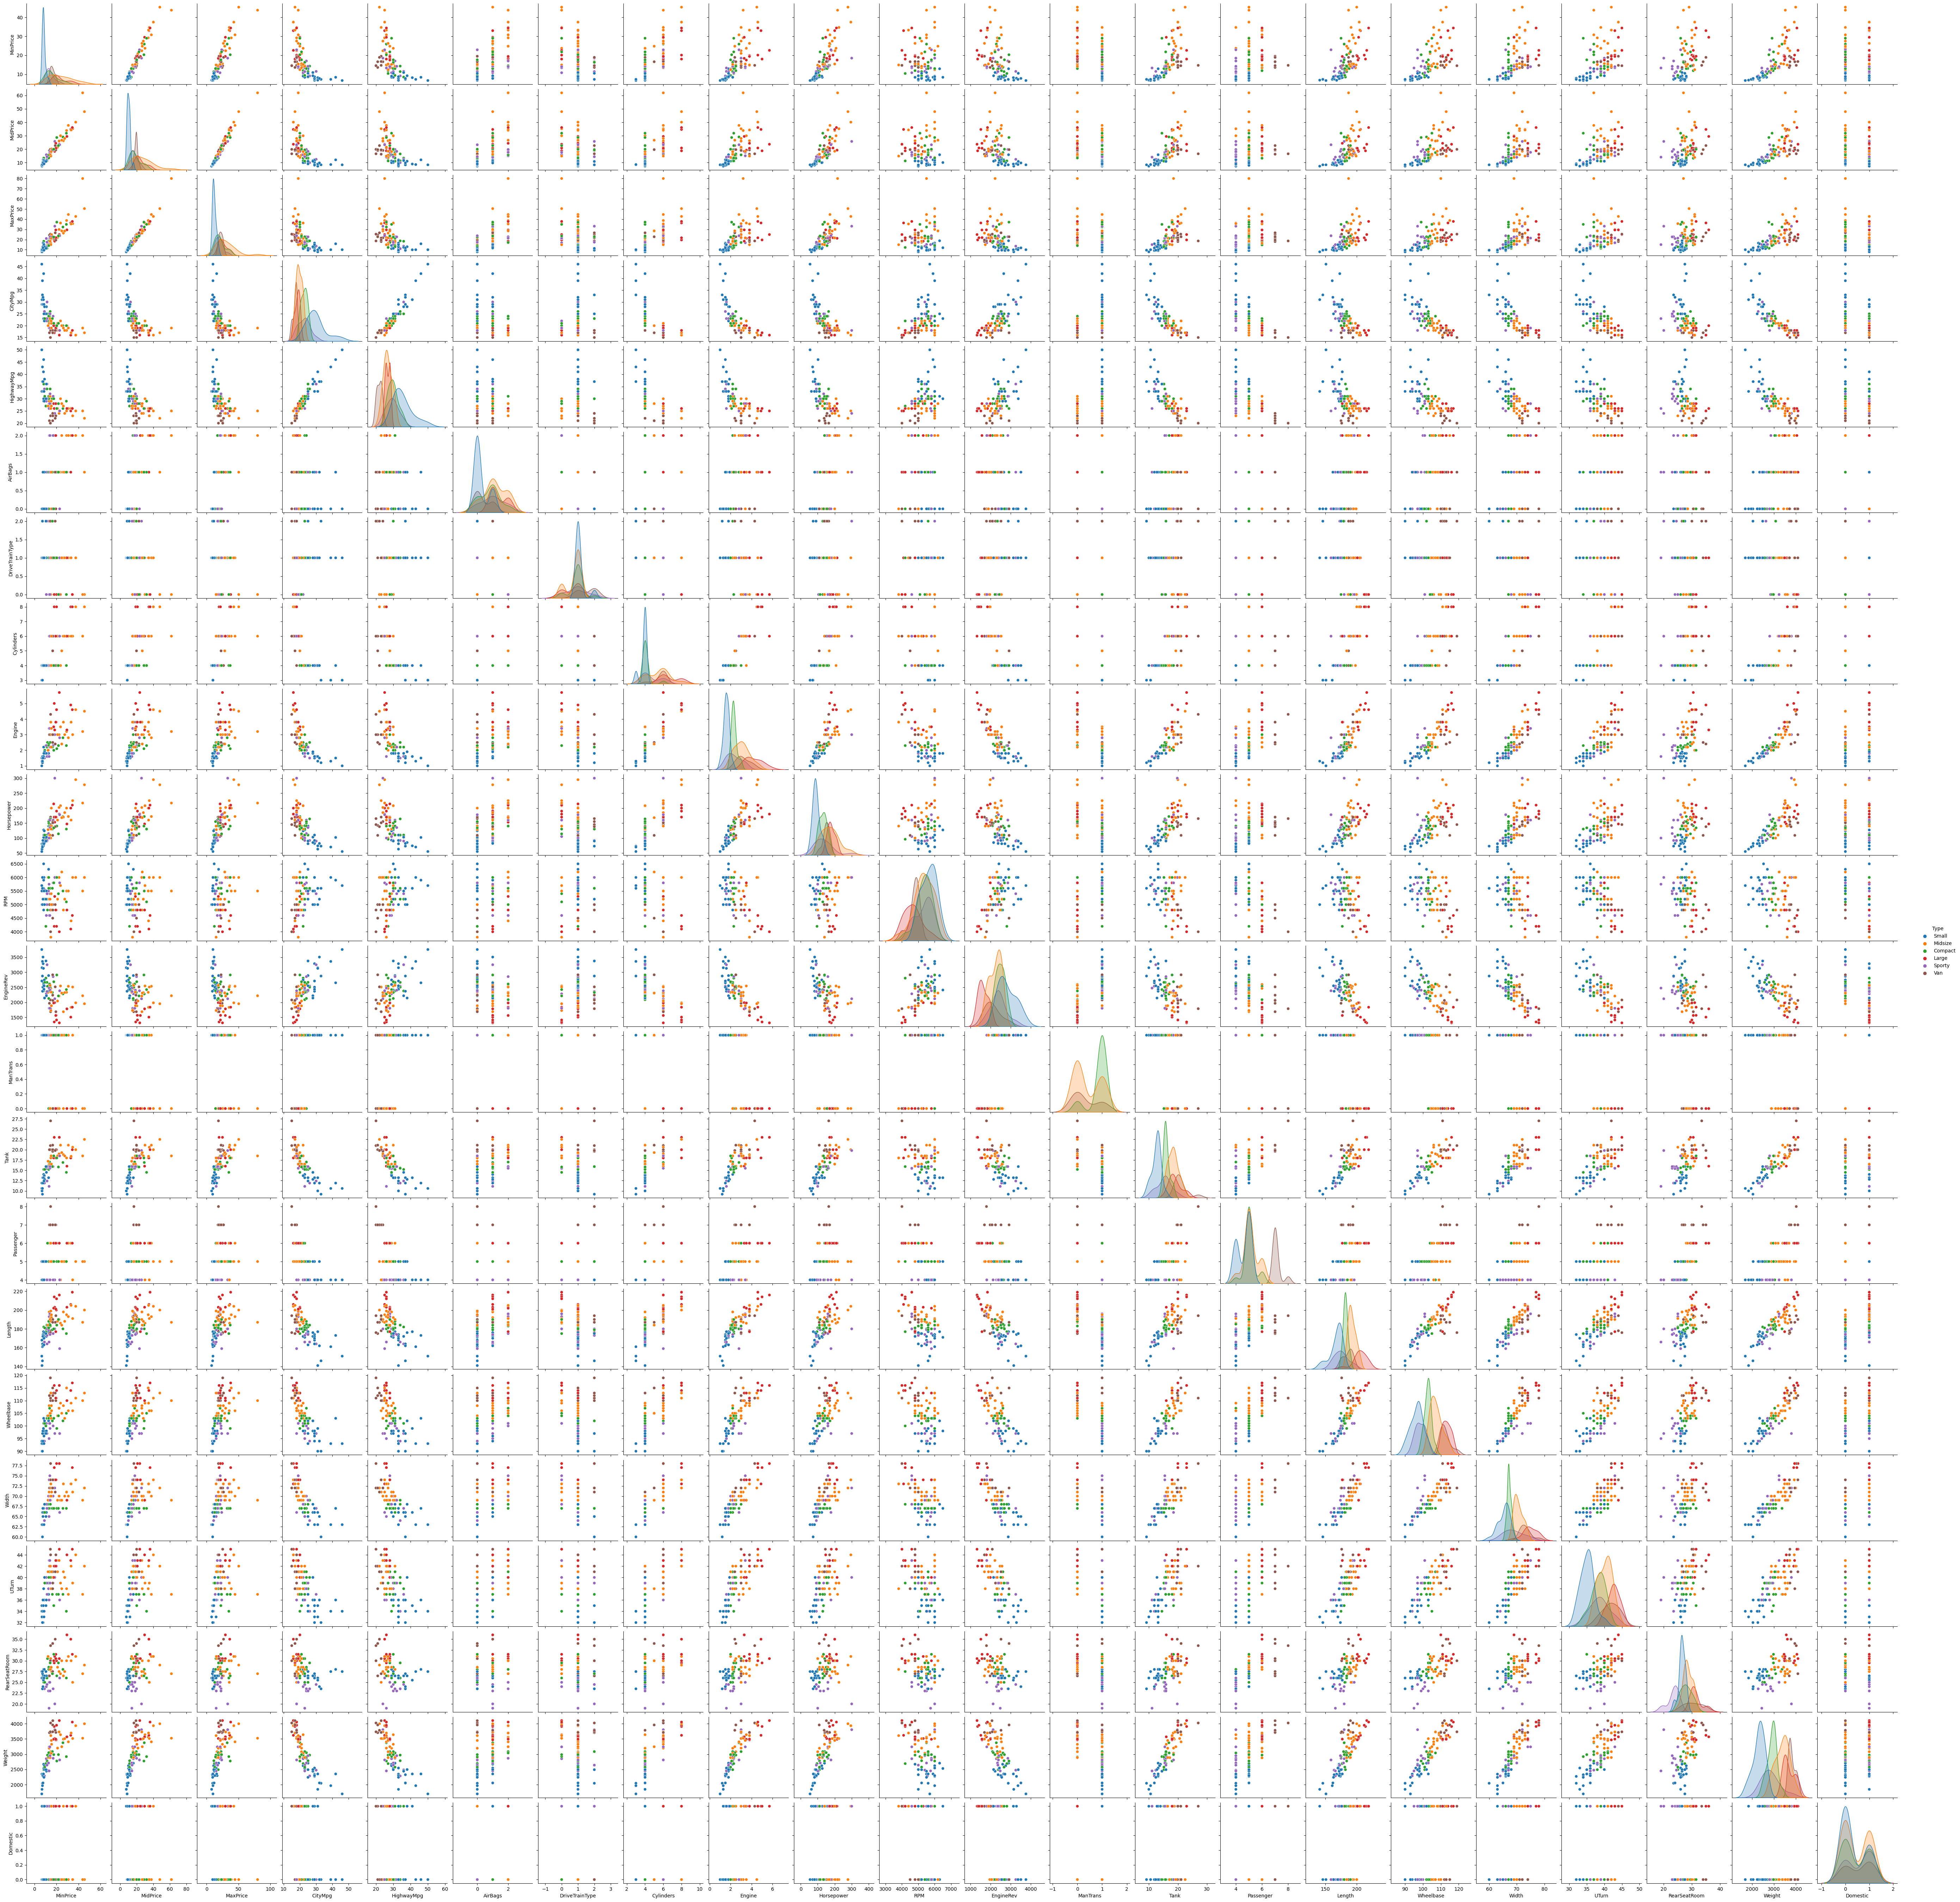

In [3]:
import seaborn as sns

# This could take a while
sns_plot = sns.pairplot(cars, hue="Type")

# uncomment to export plot
sns_plot.savefig("cars93_SPLOM_erik.pdf")

<div class="alert alert-info">
    
## 2. Understand the variables
</div>

Each car is described by a long list of variables and analyzing them individually and pair-wise will take a long time. In this assignment we will first reduce the dimensionality of the dataset and then analyze it.

### Explore scatterplot matrix

<div class="alert alert-success">
    
To understand the problem take a look at the scatterplot matrix provided in your data folder ([cars93_SPLOM.pdf](cars93_SPLOM.pdf)). What can you tell about small cars? (blue points, color legend is on the right) (no answer required and don't spend more than a few minutes)
</div>

### Explore correlation matrix

Your first task is to find groups of variables that belong together and understand their connection.
Therefore, we compute [linear correlation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) as provided by pandas. As bokeh requires the input as a linear array, we also linearize the matrix.

In [ ]:
# compute Pearson correlation
corr = cars.corr(method='pearson', numeric_only=True)
variables = list(corr)

# linearize the correlation matrix
lin_corr = pd.melt(corr.assign(index=corr.index), id_vars=['index'])
lin_corr['size'] = [abs(val)*17 for val in lin_corr.value]

The following code renders a correlation matrix using bokeh. For each pair of variables, the correlation is represented by a colored square. Size and color encode the amount of linear correlation. Large red squares indicate strong positive correlation, large blue squares strong negative correlation.

In [ ]:
p = figure(x_range=variables, y_range=variables, width=800, height=700,
           title="Correlation matrix")

p.square(source=lin_corr, x='index', y='variable', size='size', color=linear_cmap('value', 'RdYlBu7', -1, 1))

color_bar = ColorBar(color_mapper=LinearColorMapper('RdYlBu5', low=-1, high=1),
                     label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')

p.xgrid.ticker = FixedTicker(ticks=list(range(1,len(corr))))
p.ygrid.ticker = FixedTicker(ticks=list(range(1,len(corr))))
p.xaxis.major_label_orientation = -pi/4
show(p)

<div class="alert alert-success">
    
**Find groups of variables that are strongly correlated** (positive or negative). Each group consists of variables that are pair-wise strongly correlated. The example below shows the group "Properties of the engine" which consists of horsepower, engine, cylinders. 
    
**Tasks**
- Find three additional groups, name them, and list the variables that belong to them.
- Analyze if these high-level groups are correlated: Locate the positions in the matrix that encode the correlations between elements from two groups. Can you detect patterns?
- Validate your findings using the scatterplot matrix.
</div>

![](cars_corrMatrix.png)

<div class="alert alert-warning">

Groups:
- Engine properties: horsepower, engine, cylinders
- Group2
- Group3
- ...

Additional correlations between groups:
- GX + GY
- GY + GZ
- ...
</div>

<div class="alert alert-info">
    
## 3. Explained variance of PCA
</div>

Compute the [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for the cars dataset 

In [ ]:
# only use numeric attributes and exclude the type which we would like to predict
var = ['MinPrice', 'MidPrice','MaxPrice', 'CityMpg', 'HighwayMpg', 'Cylinders',
       'Engine', 'Horsepower', 'RPM', 'EngineRev',
       'Tank', 'Passenger', 'Length', 'Width', 'UTurn', 'Weight']

# store standardized data in cars_std
cars_std = StandardScaler().fit_transform(cars[var])

# store PCA in variable pca
pca = PCA( n_components=len(var) ).fit(cars_std)

In [ ]:
var_exp = pca.explained_variance_ratio_*100
cum_var_exp = np.cumsum(var_exp)
x = ['PC%s' %(i+1) for i in range(len(var))]

source = ColumnDataSource( dict(x=x, var_exp=var_exp, cum_var_exp=cum_var_exp) )

p = figure( width=520, height=400, toolbar_location=None, x_range=x, y_range=(-2,105),
            title="Explained variance of PCA of cars dataset")

p.vbar( source=source, x='x', top='var_exp', width=0.9, bottom=0, legend_label='Explained variance' )

p.circle( x, cum_var_exp, color='orange', size=5, legend_label="Cumulative explained variance")
p.line( x, cum_var_exp, color='orange', line_width=2 )

p.legend.location = (235,155)
p.legend.border_line_color = None
p.xgrid.visible = False
p.yaxis.axis_label = "Explained variance in percent"

show(p)

<div class="alert alert-success">

**Questions**
- How much variance is explained by the first two principal component(s) roughly?
- How many components do you need to explain 90% of the variance in the data (roughly, use figure estimate)?
</div>

<div class="alert alert-warning">

...
</div>

<div class="alert alert-info">
    
## 4. Interpret the projection
</div>

In [ ]:
# project the data and add the labels using the cars' type
pca_cars = pd.DataFrame( pca.transform(cars_std), columns=['PC%i' % (i+1) for i in range(pca.n_components_)])
pca_cars['label'] = cars.Type

# get the different classes in the Type variable
factors = sorted(pca_cars.label.unique())

In [ ]:
source = ColumnDataSource(pca_cars)

p = figure( width=600, height=600, y_range=(-4.5,4.8),
            title="Projection onto first two principal components")

p.circle( source=source, x='PC1', y='PC2', size=9, legend_group='label',
          color=factor_cmap('label', palette=Category10[10], factors=factors))
p.xaxis.axis_label = 'PC1' 
p.yaxis.axis_label = 'PC2' 

show(p)

<div class="alert alert-success">

**Explain the axes**

The figure above shows the projected cars data. Explain the x- and y-axis. What can you tell about cars that are located on the left/right and what about cars at the top/bottom? 
</div>

Hints:
- You cannot solve the problem using the current chart only. You need some additional technique as explained in lecture.
- The eigenvectors can be obtained through `pca.components_`
- A biplot is most helpful for the upcoming questions.

<div class="alert alert-warning">

...
</div>

<div class="alert alert-success">

**Characterize small cars**

You already tried to characterize small cars using the scatterplot matrix. Now do the same again using the PCA-plot and the analyses you made about the axes. What can you say about small cars? (small cars are red in this plot!)
    
Show a scatterplot using two informative variables to distinguish small cars from other cars.
    
Which cars are hard to distinguish from small cars?
</div>

<div class="alert alert-warning">

...
</div>

<div class="alert alert-success">

**Distinguish large cars and vans**

Show a scatterplot that makes it easy to distinguish between large cars and vans. Which two variables do you pick?
</div>

<div class="alert alert-warning">

...
</div>